In [1]:
import pickle
import pandas as pd
import pyLDAvis.gensim
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

%matplotlib inline
pyLDAvis.enable_notebook()
with open('./models/MALLET/mallet_corpus.pkl', 'rb') as corpusfile:
    corpus = pickle.load(corpusfile)

with open('./models/MALLET/mallet_dict.pkl', 'rb') as dictfile:
    dictionary = pickle.load(dictfile)    

with open('models/MALLET/mallet_model.pkl','rb') as modelfile:
    most_coherent_model = pickle.load(modelfile)

# Let's explore the generated topics
lda_model = malletmodel2ldamodel(most_coherent_model)
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/Users/jamesleung/Workspace/StashRedditTracker/venv/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/jamesleung/Workspace/StashRedditTracker/venv/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/jamesleung/Workspace/StashRedditTracker/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/jamesleung/Workspace/StashRedditTracker/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / ter

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.279250  0.053238       1        1  17.123488
1     -0.265036 -0.214111       2        1  16.972367
2      0.053834  0.281725       3        1  16.787309
0      0.240712 -0.046923       4        1  16.673797
4      0.213914 -0.242033       5        1  16.370106
5      0.035825  0.168104       6        1  16.072933, topic_info=    Category         Freq      Term        Total  loglift  logprob
13   Default  1469.000000     stock  1469.000000  30.0000  30.0000
60   Default   931.000000      card   931.000000  29.0000  29.0000
73   Default  1257.000000   account  1257.000000  28.0000  28.0000
5    Default   731.000000  dividend   731.000000  27.0000  27.0000
165  Default  2582.000000     stash  2582.000000  26.0000  26.0000
..       ...          ...       ...          ...      ...      ...
205   Topic6   224.539754       etf   657.912953   0.7530  -3.9706
9     Topic6   133.621817      make   374.736702   0.7968  -4.4897
318   Topic6   111.581105      work   226.535183   1.1199  -4.6699
615   Topic6    99.183204       ago   161.265098   1.3420  -4.7877
326   Topic6    89.540393       add   172.779529   1.1707  -4.8900

[459 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2203      5  1.135190     accessing
2057      2  0.757065  accompanying
73        4  0.768766       account
73        5  0.231345       account
978       6  1.001282         acorn
...     ...       ...           ...
1319      5  0.991039     yesterday
1246      2  0.984815         yield
1246      6  0.014273         yield
439       2  0.991394         young
2647      1  1.121435           yum

[480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5, 6])

Topic 1: Portfolio Mix and General Investing  
Topic 2: Timing the market   
Topic 3: Monthly Fees and Costs   
Topic 4: Bank: Metal Debit Cards, Founder Status   
Topic 5: Transfers, Purchases, and Deposits   
Topic 6: Amount to Invest and Autostashing   

In [2]:
df = pd.read_pickle('data/tmp/final.pkl')
topic_columns = [col for col in df.columns if col.startswith("Topic: ")]
df['Topic'] = df[topic_columns].idxmax(axis=1).str.lstrip('Topic: ').astype(int)
df = df.rename(columns={
    'Topic: 1': 'Topic 1: Portfolio Mix and General Investing',
    'Topic: 2': 'Topic 2: Timing the Market',
    'Topic: 3': 'Topic 3: Monthly Fees and Costs',
    'Topic: 4': 'Topic 4: Bank - Metal Debit Cards, Founder Status',
    'Topic: 5': 'Topic 5: Transfers, Purchases, and Deposits',
    'Topic: 6': 'Topic 6: Amount to invest and Autostashing'
})

for col in df.columns:
    if col.startswith("Topic "):
        name = col.lstrip("Topic ")
        df[f'Upvotes {name}'] = df[col]*df['upvotes']
    
upvote_columns = [col for col in df.columns if col.startswith('Upvotes ')]
df[upvote_columns].sum().sort_values(ascending=False)

Upvotes 2: Timing the Market                           760.016031
Upvotes 3: Monthly Fees and Costs                      733.011675
Upvotes 5: Transfers, Purchases, and Deposits          731.658352
Upvotes 6: Amount to invest and Autostashing           723.118488
Upvotes 1: Portfolio Mix and General Investing         719.901496
Upvotes 4: Bank - Metal Debit Cards, Founder Status    713.293958
dtype: float64

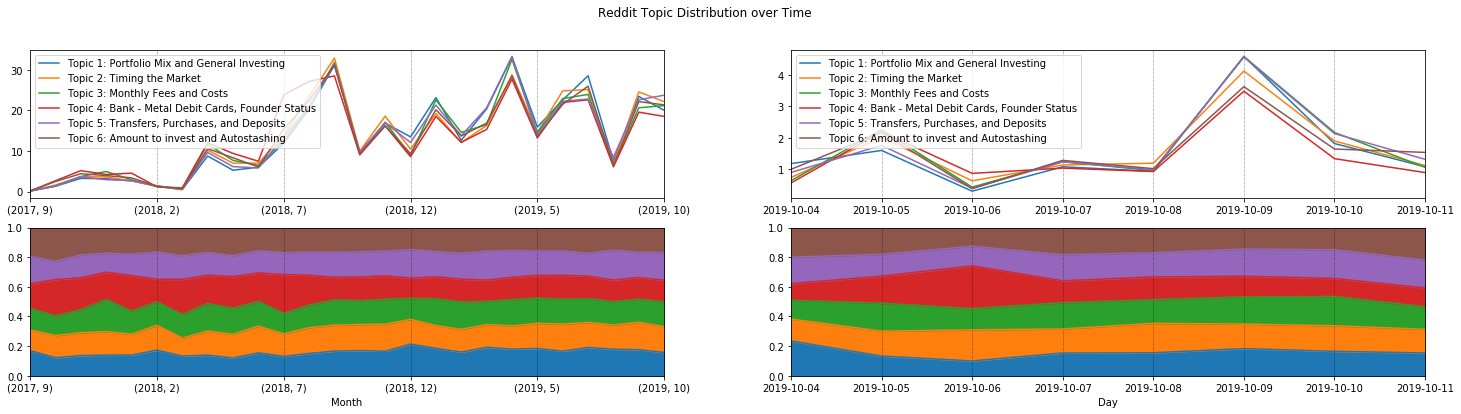

In [4]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(25,6))
df['date'] = df['time'].dt.date
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year

topic_columns = [col for col in df.columns if col.startswith('Topic ')]

# Plot the first Graph: Topic Timeseries
topics_by_month = df.groupby(['year','month']).sum()[topic_columns]
_ = topics_by_month.plot(ax=ax[0][0])
_ = ax[0][0].grid(b=True, axis='x',linestyle=':', linewidth='0.5', color='black')
_ = ax[0][0].set_xlabel('')

_ = df[df['time'] >= datetime.now() - timedelta(days=7)].groupby('date').sum()[topic_columns].plot(ax=ax[0][1])
_ = ax[0][1].grid(b=True, axis='x',linestyle=':', linewidth='0.5', color='black')
_ = ax[0][1].set_xlabel('')

# Plot the Second Graph: Topic Distribution
percentage = topics_by_month.div(topics_by_month.sum(axis=1), axis=0)
_ = percentage.plot(ax=ax[1][0], kind='area', stacked=True, legend=False)
_ = ax[1][0].set_xlabel('Month')
_ = ax[1][0].set_ylim((0,1))
_ = ax[1][0].grid(axis='x',linestyle=':', linewidth='0.5', color='black')

topics_by_day = df[df['time'] >= datetime.now() - timedelta(days=7)].groupby(['date']).sum()[topic_columns]
percentage = topics_by_day.div(topics_by_day.sum(axis=1), axis=0)

_ = percentage.plot(ax=ax[1][1], kind='area', stacked=True, legend=False)
_ = ax[1][1].set_xlabel('Day')
_ = ax[1][1].set_ylim((0,1))
_ = ax[1][1].grid(axis='x',linestyle=':', linewidth='0.5', color='black')

_ = fig.suptitle("Reddit Topic Distribution over Time")

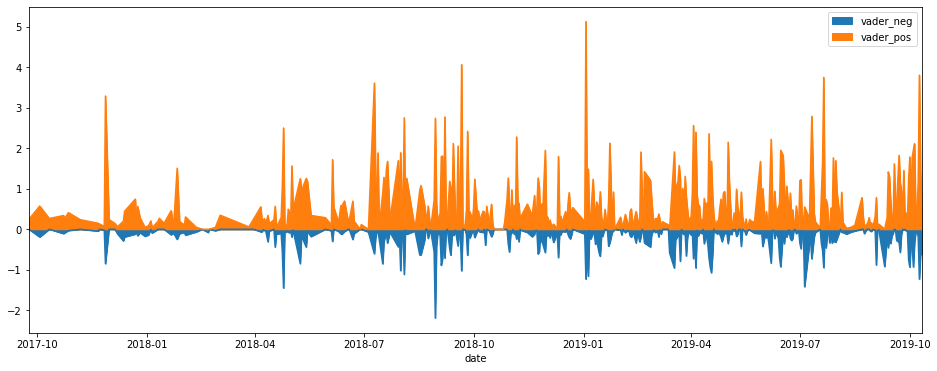

In [6]:
fix, ax = plt.subplots(figsize=(16,6))
sentiment_by_day = df.groupby(['date']).sum()[['vader_neg','vader_pos']]
sentiment_by_day['vader_neg'] = -sentiment_by_day['vader_neg']
ax = sentiment_by_day.plot(ax=ax, kind='area')

In [23]:
from datetime import date

# From this week
this_week = df[df['date'] >= date(2019,10,7)]
this_week[this_week['flair_sentiment'] == 'NEGATIVE'].sort_values(by='upvotes', ascending=False)[['orig_text', 'upvotes', 'vader_neg']][:10]

,orig_text,upvotes,vader_neg
389,I believe if you go to their website...,6,0.028
397,No there is not unfortunately.,5,0.181
95,That checks out. Do the math:\n\n\nC...,4,0.034
1868,Its not a loan. What happens is when...,4,0.043
1556,Brokerage accounts work differently ...,3,0.030
92,When they lent out your shares was i...,2,0.112
1869,Well some people have delays. Last w...,2,0.052
1257,Correct. The wheel is a scam. It eit...,2,0.109
394,Thanks!,2,0.073
1275,Custodial does as well,1,0.000


In [32]:
df.loc[95].text

"That checks out. Do the math:\n\n\nCurrent price of AMC is $9.16. Let's say it's $10, to make the math look easier.\n    25 shares * $10 = $250 That's your principal.\nNow, the interest rate for short positions in AMC with Fidelity (an example) is 0.75%. So, per day that's\n    $250 * 0.0075 / 365 = $0.005.\nThat's what the short seller pays to his broker. You're entitled to 15% of that, or $0.00077. Per day. Or every 13 days you get one penny. Not a get-rich-quick scheme, for sure, but you're basically getting this for free.\n\nIf you are looking for more short interest, take a look at BYND. Fidelity charges 108% APR interest on short positions in that stock. But then, the risk/reward seems akin to a busker juggling chainsaws. Im not sure because they never provided documentation. They lent over 25 shares of amc stock. I found out by the dividend in lieu. They failed to provide any notification or documentation. As per the agreement, we get 15% of the revenue. I got .01 cents after c

In [33]:
df.loc[95].Topic

3

In [34]:
df.loc[95]

id                                                                                     f39hrys
time                                                                       2019-10-10 18:58:27
orig_text                                              That checks out. Do the math:\n\n\nC...
text                                                   That checks out. Do the math:\n\n\nC...
upvotes                                                                                      4
tokens                                                 [check, math, current, price, amc, l...
bow                                                    [(5, 1), (7, 1), (9, 1), (13, 2), (1...
Topic 1: Portfolio Mix and General Investing                                          0.148476
Topic 2: Timing the Market                                                             0.19764
Topic 3: Monthly Fees and Costs                                                       0.242871
Topic 4: Bank - Metal Debit Cards, Founder Status 